# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,10)})

In [2]:
from datetime import datetime 
from datetime import timedelta
from datetime import date

In [3]:
#Import the original file
df = pd.read_csv('sample.csv')
df

,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,...,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810
0,11667,14976,15623,14809,16495,11980,17264,13222,7500,5539,...,11992,12461,18500,15183,16257,17749,13842,6220,4462,8741


# I - Data_Engineering

In [4]:
def Data_Engineering(file):
    # Reading the file 
    df = pd.read_csv(file)
    
    #Starting date as the first week in a year that has 
    #the first Thursday of the year
    YEAR, MONTH,DAY= 2015,1,4
    
    # Reshape the datafame and update the indexs
    columns= df.columns
    df = df.T
    df =df.reset_index(drop=True)

    #Update the date columns by datetime values of each following week 
    for i in range(df.shape[0]):
        date = datetime(YEAR,MONTH,DAY) + timedelta(weeks = 1)
        YEAR,MONTH,DAY = date.year, date.month, date.day
        df.loc[i,1] = date
        
    # rename the columns and define 'ds' as index    
    df.columns = ['Y','ds']
    df.set_index('ds', inplace=True)
    
    #Return the standardised dataframe
    return df

In [5]:
df = Data_Engineering('sample.csv')
df.head()

,Y
ds,
2015-01-11,11667
2015-01-18,14976
2015-01-25,15623
2015-02-01,14809
2015-02-08,16495


# Data exploration

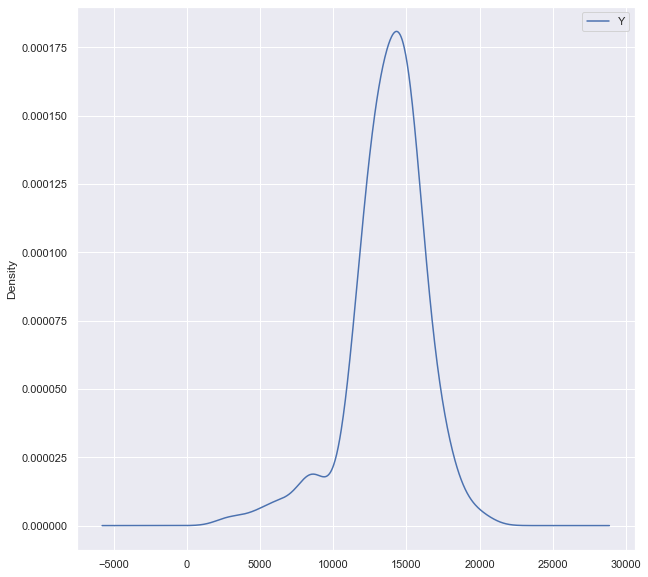

In [247]:
df.plot(kind='kde')
plt.show()


==> Histograms and density plots provide insight into the distribution of all observations, but we may be interested in the distribution of values by time interval.

## Visualizing the time series

<Figure size 1152x360 with 0 Axes>

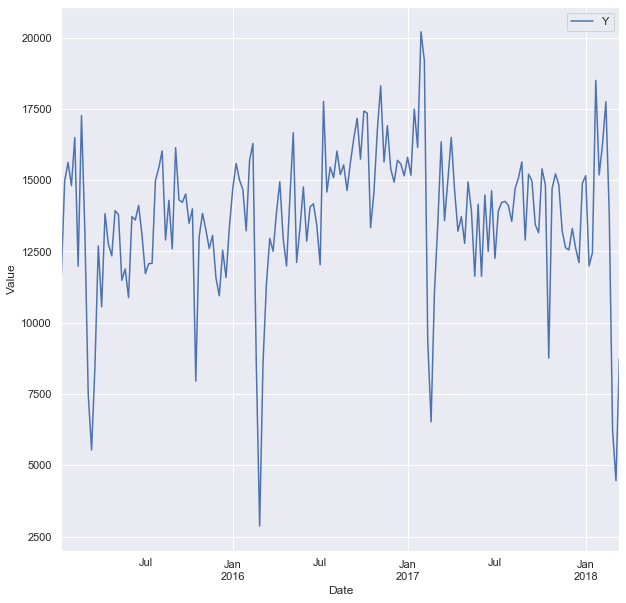

In [250]:
# Draw Plot
def plot_df(df, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5))
    df.plot()
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df)    

## Patterns in data

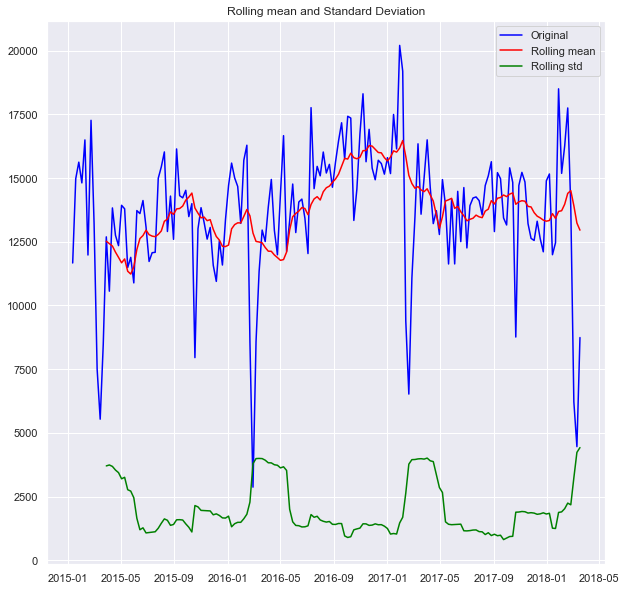

In [251]:
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()
orig = plt.plot(df, color='blue' , label ='Original')
mean = plt.plot(rolmean , color='red', label = 'Rolling mean')
std = plt.plot(rolstd , color='green', label = 'Rolling std')
plt.legend(loc='best')
plt.title('Rolling mean and Standard Deviation')
plt.show(block= False)

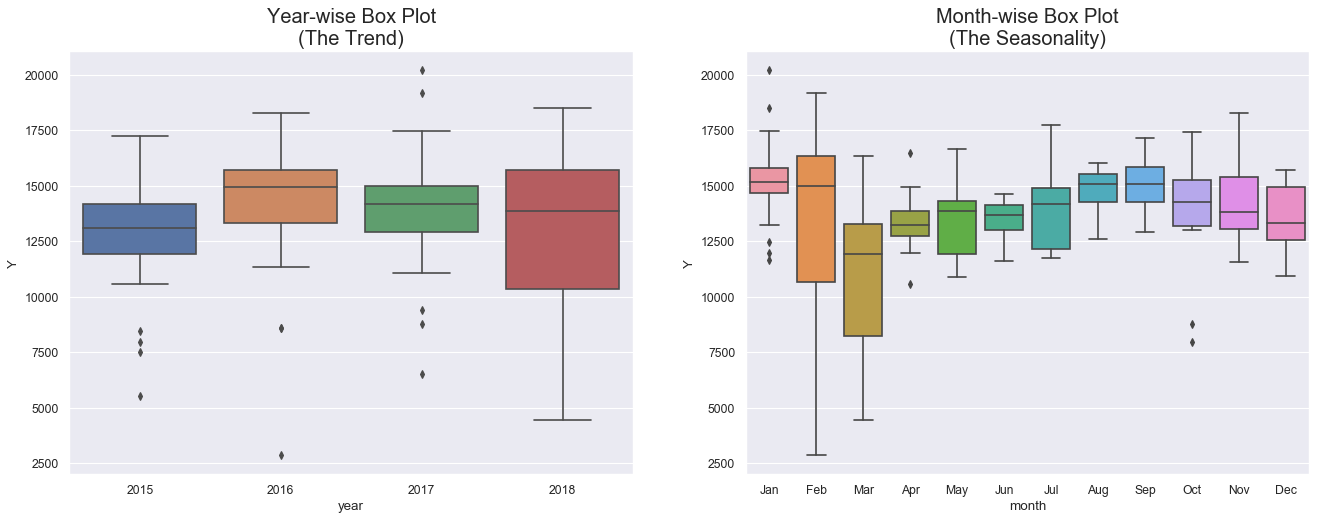

In [252]:
df_vis = df
# Prepare data
df_vis['year'] = [d.year for d in df_vis.index]
df_vis['month'] = [d.strftime('%b') for d in df_vis.index]
years = df_vis['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Y', data=df_vis, ax=axes[0])
sns.boxplot(x='month', y='Y', data=df_vis.loc[~df_vis.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()


## Time series into its components

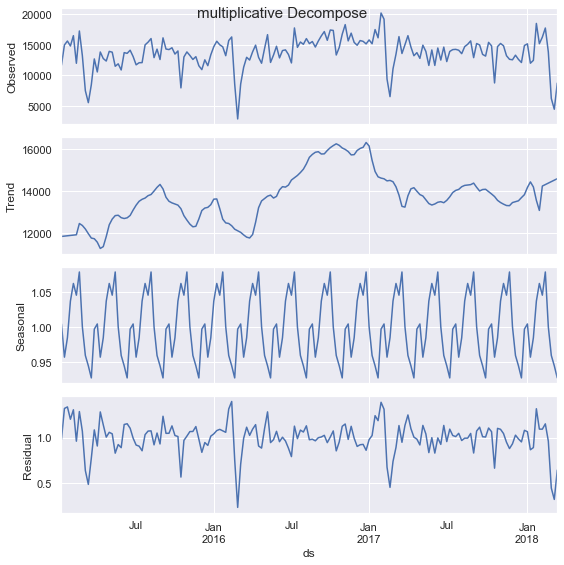

In [253]:
from dateutil.parser import parse
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df.Y, model='multiplicative',freq=12, extrapolate_trend = 12)

plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('multiplicative Decompose', fontsize=15)
plt.show()

In [11]:
# ['seas', 'trend', 'resid', 'actual_values'] For each observation 
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
ds,,,,
2015-01-11,1.004495,11858.292125,0.979465,11667
2015-01-18,0.957410,11874.156136,1.317331,14976
2015-01-25,0.984939,11890.020147,1.334051,15623
2015-02-01,1.036959,11905.884158,1.199506,14809
2015-02-08,1.061954,11921.748168,1.302887,16495


## Test  Stationarity

In [69]:
# ADF Test
from statsmodels.tsa.stattools import adfuller, kpss

result = adfuller(df['Y'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')



ADF Statistic: -6.826273636886529
p-value: 1.944269873038401e-09
Critial Values:
   1%, -3.470616369591229
Critial Values:
   5%, -2.8792214018977655
Critial Values:
   10%, -2.57619681359045


# II - Seasonality and Trend Detection 

In [67]:
# Using Gaussian process Regressor from sklearn

from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

noise = 0.2

# Use custom kernel and estimator to match examples
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

gpr.fit(X, Y)

GaussianProcessRegressor(alpha=0.04000000000000001, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=0, noise=None, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

## Hyper-parameter tuning using RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

xgb = XGBRegressor()

# Defining Hyper-parameters
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

#compute a cross-validation score for each randomly selected point in hyperparameter space
rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

rs.fit(X, Y)


## Hyperparameter tuning with Bayesian optimization


In [44]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization


# Defining Hyper-parameters
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective takes hyperparameters as input and returns a cross-validation score
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

#Initialise the optimizer
optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

optimizer.run_optimization(max_iter=20)

## Plot the result

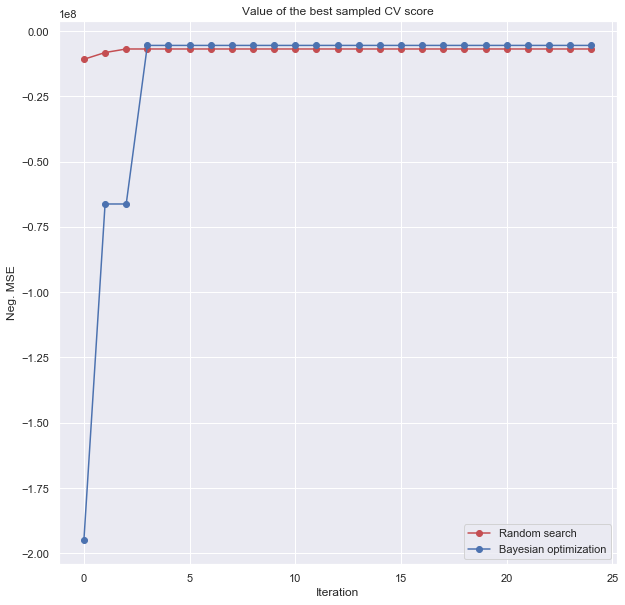

In [95]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()


plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.title('Value of the best sampled CV score');
plt.legend()

## Save  Model

In [ ]:
import pickle
with open('Model','wb') as f:
    pickle.dump(rs,f)

# II- Second function

In [91]:
def Seasonality_trend_detection(df,n):
    
    # Output Initialisation
    df1= pd.DataFrame()
    df2 = pd.DataFrame()
    index = list(df.index)
    value = list(df['Y'].values)
    targets = []
    
    # Open the model stored as pickle object
    
    pickle_in = open("Model","rb")
    model = pickle.load(pickle_in)
    
    
    
    """" First Output """
    # in the first output we will store the predictions of the 6 extra rows
    # for each value 'following week' 
    
    predictions = []
    x1 = df.values[df.shape[0]-1]
    for i in range(n):
        result = model.predict([x1])
        x1 = result
        value.append(int(result))
    
    pre_day = index[len(index)-1]
    for i in range(df.shape[0], df.shape[0]+n):
        next_day = pre_day + timedelta(weeks = 1)
        index.append(next_day)
        pre_day = next_day   
        
    df1['ds'] = index
    df1['Y']= value
    
    
    
    
    
    """" Second Output """ 
    
    # After each predictions we calculate the residuals 
    
    residuals = []
    for i in range(1, df.shape[0]):
        x2 = df.iloc[i,0]
        residual = (model.predict([x2]) - value[i])
        predictions.append(model.predict([x2]))
        targets.append( value[i])
        residuals.append(np.abs(int(residual)))
        
    for i in range(0,7):
        residuals.append(np.nan)
    
    df2['ds'] = index
    df2['Y'] = residuals
     
    
    
    return df1, df2

In [ ]:
df1, df2 = Seasonality_trend_detection(df,6)

In [93]:
df1

,ds,Y
0,2015-01-11,11667
1,2015-01-18,14976
2,2015-01-25,15623
3,2015-02-01,14809
4,2015-02-08,16495
...,...,...
168,2018-04-01,12621
169,2018-04-08,12899
170,2018-04-15,13656
171,2018-04-22,13786


In [94]:
df2

,ds,Y
0,2015-01-11,66.0
1,2015-01-18,461.0
2,2015-01-25,801.0
3,2015-02-01,2557.0
4,2015-02-08,2431.0
...,...,...
168,2018-04-01,NaN
169,2018-04-08,NaN
170,2018-04-15,NaN
171,2018-04-22,NaN
